# FETAL HEAD

## Dataset

Dataset được sử dụng là **Fetal Head Ultrasound Dataset for Image Segmentation**
(Nguồn: Kaggle – ankit8467).

Dữ liệu bao gồm:
- Ảnh siêu âm thai nhi (grayscale)
- Mask phân đoạn đầu thai nhi

### De-identification
Dữ liệu siêu âm không chứa thông tin định danh cá nhân
(tên bệnh nhân, ngày sinh, ID), đảm bảo tuân thủ đạo đức nghiên cứu y sinh.


In [ ]:
import os, shutil,zipfile, random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import roc_curve, auc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)
print("Torch:", torch.__version__)

IMG_SIZE     = 256
BATCH_SIZE  = 16
NUM_WORKERS = 0     
PIN_MEMORY  = True


Device: cuda
Torch: 2.6.0+cu118


## 1. TÁCH IMAGE / MASK

In [2]:
BASE_DIR = r"./Fetal_Head"
ZIP_PATH = os.path.join(BASE_DIR, "archive.zip")
DATASET_DIR = os.path.join(BASE_DIR, "Dataset")
WORK_DIR = os.path.join(BASE_DIR, "working")


os.makedirs(DATASET_DIR, exist_ok=True)
os.makedirs(WORK_DIR, exist_ok=True)


with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(DATASET_DIR)


RAW_DIR = os.path.join(DATASET_DIR, "training_set", "training_set")
IMG_DIR = os.path.join(WORK_DIR, "images")
MASK_DIR = os.path.join(WORK_DIR, "masks")
os.makedirs(IMG_DIR, exist_ok=True)
os.makedirs(MASK_DIR, exist_ok=True)


for f in os.listdir(RAW_DIR):
    src = os.path.join(RAW_DIR, f)
    if f.endswith('.png'):
        if 'Annotation' in f:
            shutil.copy(src, MASK_DIR)
        else:
            shutil.copy(src, IMG_DIR)   

print("Images:", len(os.listdir(IMG_DIR)))
print("Masks :", len(os.listdir(MASK_DIR)))

Images: 999
Masks : 999


## 2. THỐNG KÊ MÔ TẢ

### Số lượng, kích thước

In [3]:
img_files = sorted(os.listdir(IMG_DIR))
mask_files = sorted(os.listdir(MASK_DIR))

print("DATASET OVERVIEW")
print("-" * 30)
print(f"Total images : {len(img_files)}")
print(f"Total masks  : {len(mask_files)}")

assert len(img_files) == len(mask_files), "Mismatch between images and masks!"
print("✔ Image–Mask pairing: OK")


sizes = []
for f in img_files:
    img = Image.open(os.path.join(IMG_DIR, f))
    sizes.append(img.size)  # (W, H)

widths  = [s[0] for s in sizes]
heights = [s[1] for s in sizes]

print("\nIMAGE SIZE STATISTICS")
print("-" * 30)
print(f"Min width  : {min(widths)}")
print(f"Max width  : {max(widths)}")
print(f"Min height : {min(heights)}")
print(f"Max height : {max(heights)}")
print(f"Mean size  : {np.mean(widths):.1f} × {np.mean(heights):.1f}")




DATASET OVERVIEW
------------------------------
Total images : 999
Total masks  : 999
✔ Image–Mask pairing: OK

IMAGE SIZE STATISTICS
------------------------------
Min width  : 738
Max width  : 800
Min height : 539
Max height : 563
Mean size  : 799.8 × 540.1


### Phân bố diện tích mask


MASK AREA STATISTICS (Foreground Pixels)
----------------------------------------
Min area   : 1116
Max area   : 4524
Mean area  : 3207.1
Median     : 3316.0


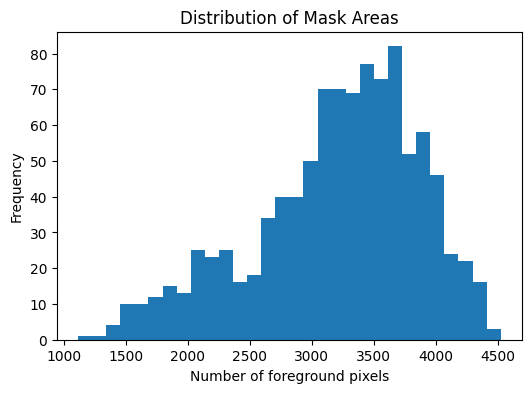

In [4]:
mask_areas = []

for f in mask_files:
    mask = cv2.imread(os.path.join(MASK_DIR, f), 0)
    mask = (mask > 0).astype(np.uint8)
    area = mask.sum()
    mask_areas.append(area)

mask_areas = np.array(mask_areas)

print("\nMASK AREA STATISTICS (Foreground Pixels)")
print("-" * 40)
print(f"Min area   : {mask_areas.min()}")
print(f"Max area   : {mask_areas.max()}")
print(f"Mean area  : {mask_areas.mean():.1f}")
print(f"Median     : {np.median(mask_areas):.1f}")


plt.figure(figsize=(6,4))
plt.hist(mask_areas, bins=30)
plt.title("Distribution of Mask Areas")
plt.xlabel("Number of foreground pixels")
plt.ylabel("Frequency")
plt.show()


### Cường độ ảnh


IMAGE INTENSITY STATISTICS
----------------------------------------
Min intensity : 0
Max intensity : 250
Mean intensity: 46.20
Std intensity : 46.60


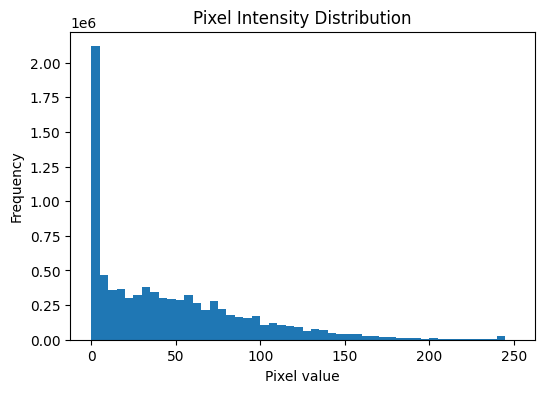

In [5]:
sample_pixels = []

for f in img_files[:20]:  # sample 20 images
    img = cv2.imread(os.path.join(IMG_DIR, f), 0)
    sample_pixels.extend(img.flatten())

sample_pixels = np.array(sample_pixels)

print("\nIMAGE INTENSITY STATISTICS")
print("-" * 40)
print(f"Min intensity : {sample_pixels.min()}")
print(f"Max intensity : {sample_pixels.max()}")
print(f"Mean intensity: {sample_pixels.mean():.2f}")
print(f"Std intensity : {sample_pixels.std():.2f}")


plt.figure(figsize=(6,4))
plt.hist(sample_pixels, bins=50)
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.show()


## 3. DATASET CLASS

In [112]:
class FetalHeadDataset(Dataset):
    def __init__(self, img_dir, mask_dir, augment=False):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.images = sorted(os.listdir(img_dir))
        self.masks  = sorted(os.listdir(mask_dir))
        self.augment = augment

        self.img_tf = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # IMAGE
        img = Image.open(os.path.join(self.img_dir, self.images[idx])).convert("L")
        img = self.img_tf(img)

        # MASK (FILLED)
        mask = cv2.imread(os.path.join(self.mask_dir, self.masks[idx]), 0)

        contours, _ = cv2.findContours(
            mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        filled_mask = np.zeros_like(mask)
        cv2.drawContours(filled_mask, contours, -1, 1, thickness=-1)

        filled_mask = cv2.resize(
            filled_mask, (IMG_SIZE, IMG_SIZE),
            interpolation=cv2.INTER_NEAREST
        )

        mask = torch.from_numpy(filled_mask).float().unsqueeze(0)

        return img, mask


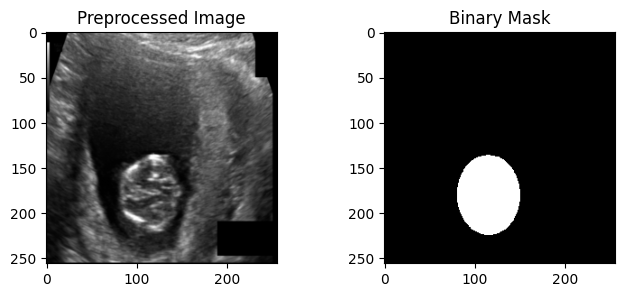

In [113]:
dataset = FetalHeadDataset(IMG_DIR, MASK_DIR)

img, mask = dataset[0]

plt.figure(figsize=(8,3))

plt.subplot(1,2,1)
plt.imshow(img[0], cmap="gray")
plt.title("Preprocessed Image")

plt.subplot(1,2,2)
plt.imshow(mask[0], cmap="gray")
plt.title("Binary Mask")

plt.show()


## 4. KIỂM TRA

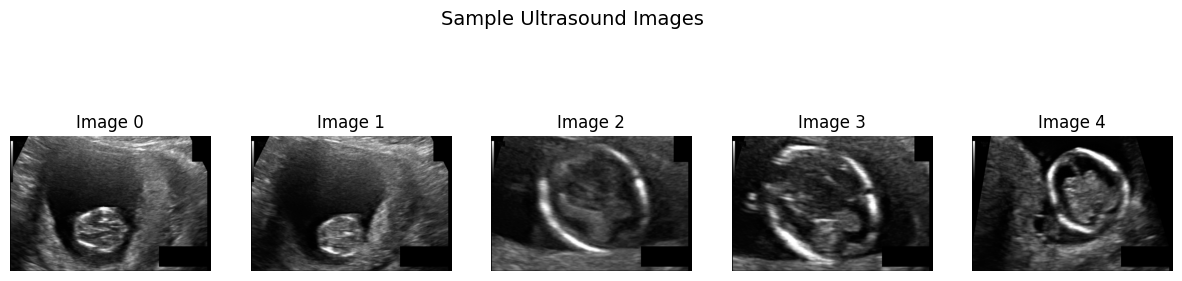

In [114]:
sample_imgs = sorted(os.listdir(IMG_DIR))[:5]

fig, ax = plt.subplots(1, 5, figsize=(15,4))
for i, f in enumerate(sample_imgs):
    img = Image.open(os.path.join(IMG_DIR, f))
    ax[i].imshow(img, cmap="gray")
    ax[i].set_title(f"Image {i}")
    ax[i].axis("off")

plt.suptitle("Sample Ultrasound Images", fontsize=14)
plt.show()


### KIỂM TRA MASK

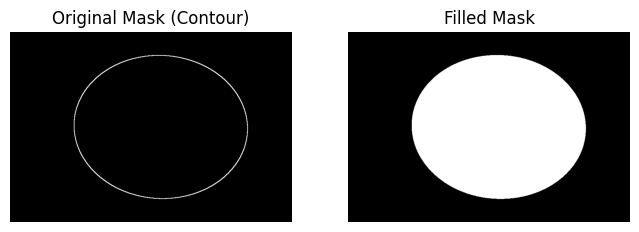

In [115]:
mask = cv2.imread(os.path.join(MASK_DIR, "828_HC_Annotation.png"), 0)

contours, _ = cv2.findContours(
    mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

filled_mask = np.zeros_like(mask)
cv2.drawContours(filled_mask, contours, -1, 255, thickness=-1)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title("Original Mask (Contour)")
plt.imshow(mask, cmap="gray")
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Filled Mask")
plt.imshow(filled_mask, cmap="gray")
plt.axis("off")

plt.show()


### HÀM PADDING(812×812)

In [116]:
def pad_to_square(img, target_size=812):
    c, h, w = img.shape
    pad_h = target_size - h
    pad_w = target_size - w

    pad_top = pad_h // 2
    pad_bottom = pad_h - pad_top
    pad_left = pad_w // 2
    pad_right = pad_w - pad_left

    return F.pad(img, (pad_left, pad_right, pad_top, pad_bottom), value=0)


### KIỂM TRA IMAGE + MASK + OVERLAY

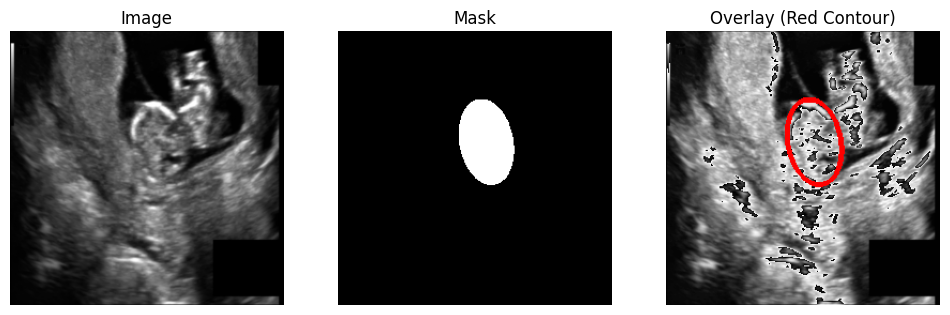

In [117]:
dataset = FetalHeadDataset(IMG_DIR, MASK_DIR)
img, mask = dataset[10]  # img, mask: torch.Tensor [1,H,W]

img_np  = img[0].numpy()
mask_np = mask[0].numpy().astype(np.uint8)

# tìm contour từ mask
contours, _ = cv2.findContours(
    mask_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

overlay = cv2.cvtColor((img_np*255).astype(np.uint8), cv2.COLOR_GRAY2BGR)

# vẽ viền đỏ đậm
cv2.drawContours(
    overlay,
    contours,
    -1,
    color=(255, 0, 0),   # đỏ
    thickness=3         # <<== ĐẬM HƠN
)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img_np, cmap="gray")
plt.title("Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(mask_np, cmap="gray")
plt.title("Mask")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay (Red Contour)")
plt.axis("off")

plt.show()


### HIỂN THỊ ẢNH

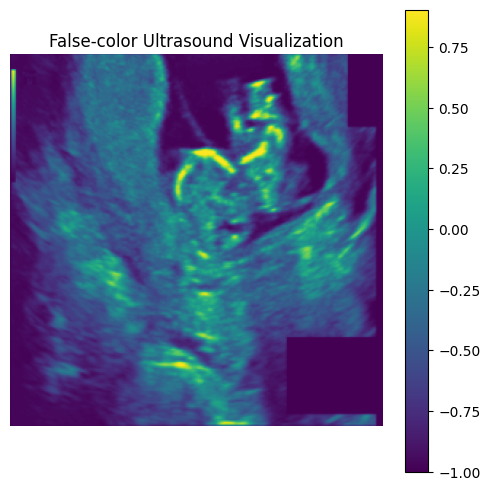

In [118]:
plt.figure(figsize=(6,6))
plt.imshow(img_np, cmap="viridis")
plt.colorbar()
plt.title("False-color Ultrasound Visualization")
plt.axis("off")
plt.show()


## 5. AUGMENTATION

In [119]:
class AugmentedDataset(FetalHeadDataset):
    def __getitem__(self, idx):
        img, mask = super().__getitem__(idx)

        if random.random() > 0.5:
            img = TF.hflip(img)
            mask = TF.hflip(mask)

        if random.random() > 0.5:
            angle = random.uniform(-15, 15)
            img = TF.rotate(img, angle)
            mask = TF.rotate(mask, angle)

        if random.random() > 0.5:
            scale = random.uniform(0.9, 1.1)
            h, w = img.shape[-2:]
            new_size = int(h * scale)

            img = TF.resize(img, new_size)
            mask = TF.resize(mask, new_size, interpolation=TF.InterpolationMode.NEAREST)

            img = TF.center_crop(img, (h, w))
            mask = TF.center_crop(mask, (h, w))

        return img, mask


## 6. TRAIN/VAL/TEST

In [120]:
full_dataset = FetalHeadDataset(IMG_DIR, MASK_DIR)
n = len(full_dataset)

idx = list(range(n))
random.shuffle(idx)

train_idx = idx[:int(0.7*n)]
val_idx   = idx[int(0.7*n):int(0.85*n)]
test_idx  = idx[int(0.85*n):]

train_set = FetalHeadDataset(IMG_DIR, MASK_DIR, augment=True)
val_set   = FetalHeadDataset(IMG_DIR, MASK_DIR)
test_set  = FetalHeadDataset(IMG_DIR, MASK_DIR)

train_set.images = [full_dataset.images[i] for i in train_idx]
train_set.masks  = [full_dataset.masks[i]  for i in train_idx]

val_set.images = [full_dataset.images[i] for i in val_idx]
val_set.masks  = [full_dataset.masks[i]  for i in val_idx]

test_set.images = [full_dataset.images[i] for i in test_idx]
test_set.masks  = [full_dataset.masks[i]  for i in test_idx]


total_samples = len(dataset)

print("DATASET SPLIT SUMMARY")
print("-" * 30)
print(f"Total samples : {total_samples}")
print(f"Train samples : {len(train_set)} ({len(train_set)/total_samples:.1%})")
print(f"Val samples   : {len(val_set)} ({len(val_set)/total_samples:.1%})")
print(f"Test samples  : {len(test_set)} ({len(test_set)/total_samples:.1%})")
print("-" * 30)


print("Index ranges:")
print(f"Train index range: [{min(train_idx)} – {max(train_idx)}]")
print(f"Val index range  : [{min(val_idx)} – {max(val_idx)}]")
print(f"Test index range : [{min(test_idx)} – {max(test_idx)}]")


DATASET SPLIT SUMMARY
------------------------------
Total samples : 999
Train samples : 699 (70.0%)
Val samples   : 150 (15.0%)
Test samples  : 150 (15.0%)
------------------------------
Index ranges:
Train index range: [1 – 998]
Val index range  : [22 – 992]
Test index range : [0 – 994]


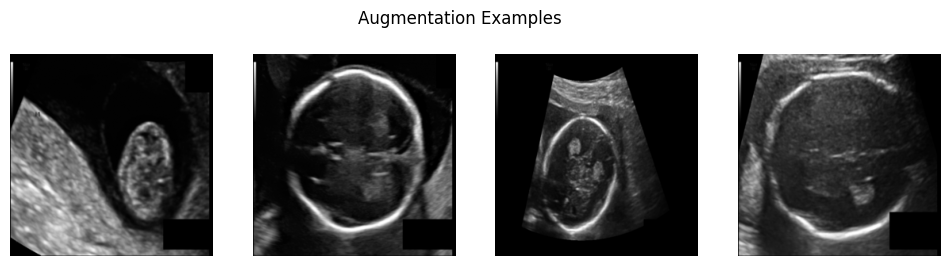

In [121]:
aug = train_set   # dataset có augmentation

fig, ax = plt.subplots(1,4, figsize=(12,3))

for i in range(4):
    im, _ = aug[i]   # lấy i khác nhau
    ax[i].imshow(im[0], cmap="gray")
    ax[i].axis("off")

plt.suptitle("Augmentation Examples")
plt.show()


## 7. DATALOADER

In [122]:
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,     
    pin_memory=True
)

val_loader = DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

test_loader = DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)


## 8. U-NET

In [123]:
def CBR(in_ch, out_ch):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, 3, padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_ch, out_ch, 3, padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True)
    )

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.e1 = CBR(1, 64)
        self.e2 = CBR(64, 128)
        self.e3 = CBR(128, 256)
        self.e4 = CBR(256, 512)
        self.pool = nn.MaxPool2d(2)

        self.bottleneck = CBR(512, 1024)

        self.u4 = nn.ConvTranspose2d(1024, 512, 2, 2)
        self.d4 = CBR(1024, 512)

        self.u3 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.d3 = CBR(512, 256)

        self.u2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.d2 = CBR(256, 128)

        self.u1 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.d1 = CBR(128, 64)

        self.out = nn.Conv2d(64, 1, kernel_size=1)  # ⚠️ logits

    def forward(self, x):
        e1 = self.e1(x)
        e2 = self.e2(self.pool(e1))
        e3 = self.e3(self.pool(e2))
        e4 = self.e4(self.pool(e3))
        b  = self.bottleneck(self.pool(e4))

        d4 = self.d4(torch.cat([self.u4(b), e4], dim=1))
        d3 = self.d3(torch.cat([self.u3(d4), e3], dim=1))
        d2 = self.d2(torch.cat([self.u2(d3), e2], dim=1))
        d1 = self.d1(torch.cat([self.u1(d2), e1], dim=1))

        return self.out(d1)


## 9. LOSS, METRICS

In [124]:
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        inter = (probs * targets).sum(dim=(1,2,3))
        union = probs.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))
        dice = (2 * inter + self.eps) / (union + self.eps)
        return 1 - dice.mean()

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        pt = torch.where(targets == 1, probs, 1 - probs)
        loss = -self.alpha * (1 - pt) ** self.gamma * torch.log(pt + 1e-6)
        return loss.mean()

dice_loss  = DiceLoss()
focal_loss = FocalLoss()

def combined_loss(logits, targets):
    return 0.7 * dice_loss(logits, targets) + 0.3 * focal_loss(logits, targets)


def dice_score(logits, targets, threshold=0.5, eps=1e-6):
    probs = torch.sigmoid(logits)
    preds = (probs > threshold).float()

    inter = (preds * targets).sum(dim=(1,2,3))
    union = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))

    dice = (2 * inter + eps) / (union + eps)
    return dice.mean()


def sensitivity_specificity(logits, targets, threshold=0.5, eps=1e-6):
    probs = torch.sigmoid(logits)
    preds = (probs > threshold).float()

    TP = (preds * targets).sum()
    TN = ((1 - preds) * (1 - targets)).sum()
    FP = (preds * (1 - targets)).sum()
    FN = ((1 - preds) * targets).sum()

    sens = TP / (TP + FN + eps)
    spec = TN / (TN + FP + eps)

    return sens.item(), spec.item()




In [151]:
num_epochs = 10
learning_rate = 1e-4
batch_size = 8
loss_name = "BCEWithLogitsLoss"
optimizer_name = "Adam"

print("=== TRAINING CONFIG ===")
print("Epochs:", num_epochs)
print("Learning rate:", learning_rate)
print("Batch size:", batch_size)
print("Loss:", loss_name)
print("Optimizer:", optimizer_name)


=== TRAINING CONFIG ===
Epochs: 10
Learning rate: 0.0001
Batch size: 8
Loss: BCEWithLogitsLoss
Optimizer: Adam


In [126]:
model = UNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == "cuda"))

print(model)
print("Total params:",
      sum(p.numel() for p in model.parameters()))


UNet(
  (e1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (e2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (e3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running

C:\Users\Non\AppData\Local\Temp\ipykernel_23484\4130423278.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == "cuda"))


In [152]:
x, y = next(iter(train_loader))
print(x.shape, y.shape)


torch.Size([16, 1, 256, 256]) torch.Size([16, 1, 256, 256])


## 10. TRAINING LOOP

In [129]:
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == "cuda"))

NUM_EPOCHS = 10
train_losses, val_losses = [], []
best_val = 1e9

for epoch in range(NUM_EPOCHS):

    # ===== TRAIN =====
    model.train()
    train_total = 0

    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()

        
        with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):
            logits = model(x)
            loss = combined_loss(logits, y)

        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_total += loss.item()

    train_loss = train_total / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_total = 0

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)
            val_total += combined_loss(logits, y).item()

    val_loss = val_total / len(val_loader)
    val_losses.append(val_loss)

    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), "best_unet.pt")
        print("✅ Saved best model")

    print(f"Epoch {epoch:02d} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f}")


C:\Users\Non\AppData\Local\Temp\ipykernel_23484\2814027201.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == "cuda"))
C:\Users\Non\AppData\Local\Temp\ipykernel_23484\2814027201.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):


✅ Saved best model
Epoch 00 | Train Loss: 0.2619 | Val Loss: 0.2258
✅ Saved best model
Epoch 01 | Train Loss: 0.1577 | Val Loss: 0.1318
✅ Saved best model
Epoch 02 | Train Loss: 0.1252 | Val Loss: 0.1083
✅ Saved best model
Epoch 03 | Train Loss: 0.1031 | Val Loss: 0.0965
✅ Saved best model
Epoch 04 | Train Loss: 0.0841 | Val Loss: 0.0732
✅ Saved best model
Epoch 05 | Train Loss: 0.0716 | Val Loss: 0.0687
✅ Saved best model
Epoch 06 | Train Loss: 0.0647 | Val Loss: 0.0607
✅ Saved best model
Epoch 07 | Train Loss: 0.0597 | Val Loss: 0.0559
✅ Saved best model
Epoch 08 | Train Loss: 0.0511 | Val Loss: 0.0502
✅ Saved best model
Epoch 09 | Train Loss: 0.0466 | Val Loss: 0.0449


In [130]:
model.load_state_dict(torch.load("best_unet.pt"))
model.eval()

UNet(
  (e1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (e2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (e3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running

In [131]:
model.eval()
img, mask = test_set[0]

with torch.no_grad():
    logit = model(img.unsqueeze(0).to(DEVICE))
    prob  = torch.sigmoid(logit)

print("Logits min:", logit.min().item())
print("Logits max:", logit.max().item())
print("Prob min  :", prob.min().item())
print("Prob max  :", prob.max().item())


Logits min: -5.635677337646484
Logits max: 7.328853130340576
Prob min  : 0.0035555721260607243
Prob max  : 0.9993440508842468


## 11. LOSS CURVE


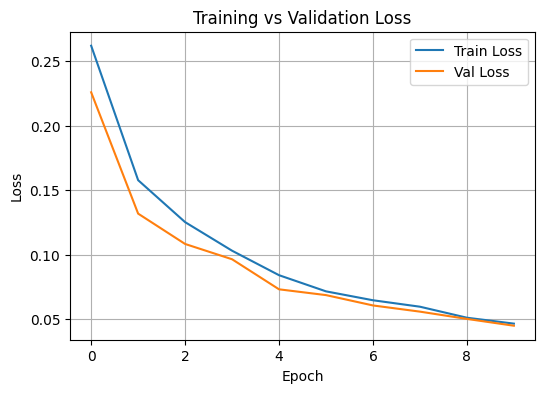

In [134]:
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()


## 12. Dice Score/ Sensitivity / Specificity

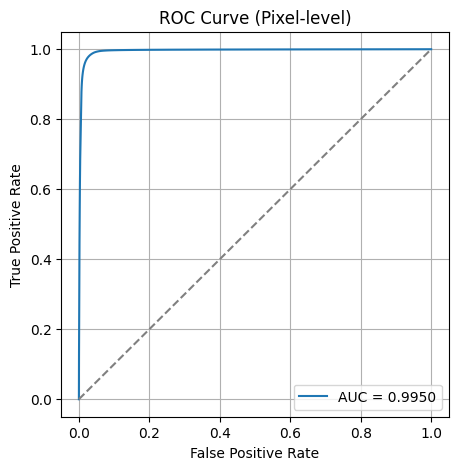

In [136]:
from sklearn.metrics import roc_curve, auc

model.eval()

all_probs = []
all_targets = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(DEVICE)
        logits = model(x)
        probs = torch.sigmoid(logits)

        all_probs.append(probs.cpu().numpy().ravel())
        all_targets.append(y.cpu().numpy().astype(np.uint8).ravel())

all_probs = np.concatenate(all_probs)
all_targets = np.concatenate(all_targets)

fpr, tpr, _ = roc_curve(all_targets, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], '--', color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Pixel-level)")
plt.legend()
plt.grid(True)
plt.show()


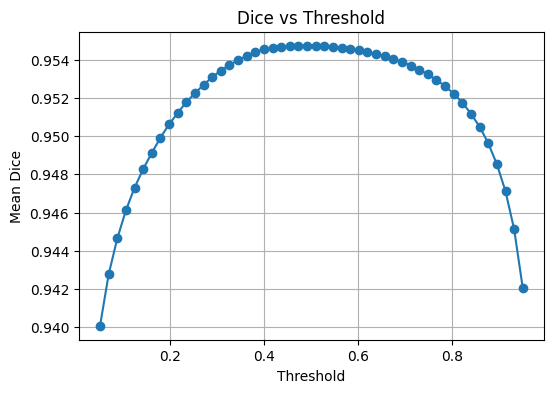

Best threshold: 0.49
Best Dice     : 0.9547


In [137]:
thresholds = np.linspace(0.05, 0.95, 50)
dice_scores = []

N = len(test_set)
idx = 0

for th in thresholds:
    dices = []

    for i in range(N):
        p = all_probs[idx: idx + 256*256]
        t = all_targets[idx: idx + 256*256]
        idx += 256*256

        pred = (p > th).astype(np.float32)

        inter = (pred * t).sum()
        union = pred.sum() + t.sum()

        dices.append((2 * inter) / (union + 1e-6))

    dice_scores.append(np.mean(dices))
    idx = 0

plt.figure(figsize=(6,4))
plt.plot(thresholds, dice_scores, marker="o")
plt.xlabel("Threshold")
plt.ylabel("Mean Dice")
plt.title("Dice vs Threshold")
plt.grid(True)
plt.show()

best_idx = np.argmax(dice_scores)
best_th = thresholds[best_idx]

print(f"Best threshold: {best_th:.2f}")
print(f"Best Dice     : {dice_scores[best_idx]:.4f}")


In [138]:
dice_list, sens_list, spec_list = [], [], []

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)

        dice_list.append(dice_score(logits, y, threshold=best_th).item())
        s, sp = sensitivity_specificity(logits, y, threshold=best_th)

        sens_list.append(s)
        spec_list.append(sp)

print("\n===== FINAL TEST METRICS =====")
print(f"Dice Score  : {np.mean(dice_list):.4f}")
print(f"Sensitivity : {np.mean(sens_list):.4f}")
print(f"Specificity : {np.mean(spec_list):.4f}")
print(f"Threshold   : {best_th:.2f}")



===== FINAL TEST METRICS =====
Dice Score  : 0.9537
Sensitivity : 0.9686
Specificity : 0.9796
Threshold   : 0.49


## 13. CONFUSION MATRIX

In [140]:
TP=TN=FP=FN=0

model.eval()
with torch.no_grad():
    for x,y in test_loader:
        p = torch.sigmoid(model(x.to(DEVICE))).cpu()
        p = (p>0.5).int()
        y = y.int()

        TP += ((p==1)&(y==1)).sum().item()
        TN += ((p==0)&(y==0)).sum().item()
        FP += ((p==1)&(y==0)).sum().item()
        FN += ((p==0)&(y==1)).sum().item()

cm = np.array([[TN,FP],[FN,TP]])
print(cm)


[[6495368  135561]
 [ 100467 3099004]]


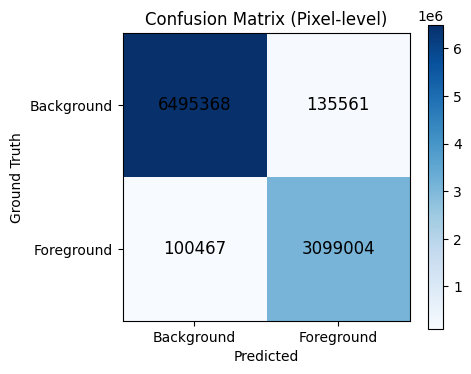

In [149]:
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues")

plt.title("Confusion Matrix (Pixel-level)")
plt.colorbar()

labels = ["Background", "Foreground"]
plt.xticks([0,1], labels)
plt.yticks([0,1], labels)

# Annotate
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center",
                 color="black", fontsize=12)

plt.xlabel("Predicted")
plt.ylabel("Ground Truth")
plt.tight_layout()
plt.show()


## 14. VISUALIZATION

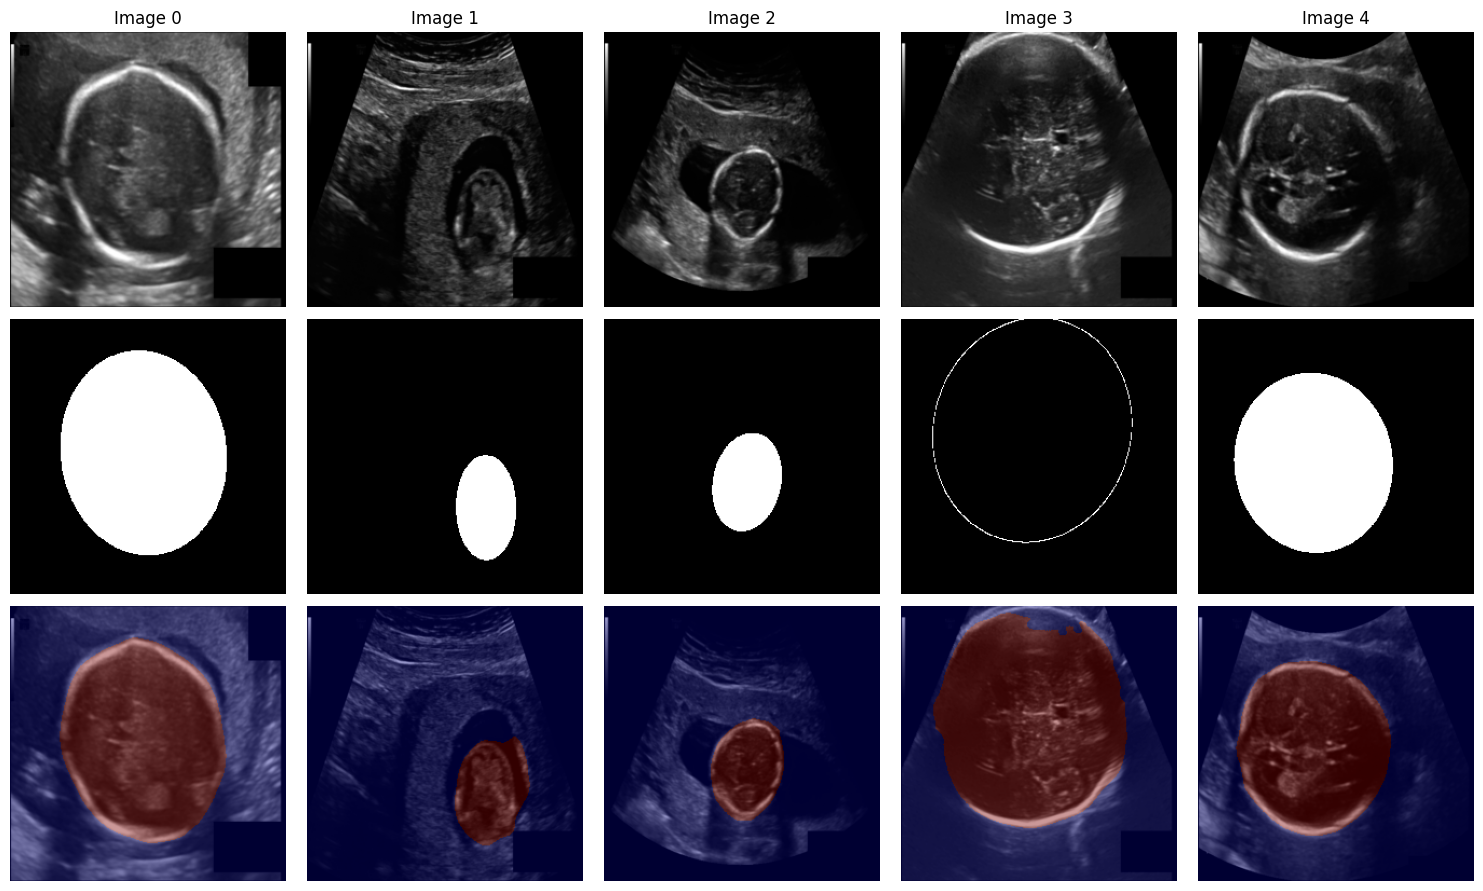

In [141]:
model.eval()

x, y = next(iter(test_loader))
x = x.to(DEVICE)
y = y.to(DEVICE)

with torch.no_grad():
    pred = torch.sigmoid(model(x))

x = x.cpu()
y = y.cpu()
pred = pred.cpu()

n = min(5, x.size(0))

fig, ax = plt.subplots(3, n, figsize=(3*n, 9))

for i in range(n):

    # Image
    ax[0,i].imshow(x[i,0], cmap="gray")
    ax[0,i].set_title(f"Image {i}")

    # Ground truth
    ax[1,i].imshow(y[i,0], cmap="gray")

    # Prediction overlay
    ax[2,i].imshow(x[i,0], cmap="gray")
    ax[2,i].imshow(pred[i,0] > 0.5, cmap="jet", alpha=0.4)

ax[0,0].set_ylabel("Image")
ax[1,0].set_ylabel("GT")
ax[2,0].set_ylabel("Prediction")

for a in ax.flatten():
    a.axis("off")

plt.tight_layout()
plt.show()


## 15. ERROR ANALYSIS SUPPORT

In [148]:
model.eval()
dice_scores = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        p = torch.sigmoid(model(x))
        p = (p > 0.5).float()
        d = dice_score(p, y)
        dice_scores.append(d.item())

dice_scores = np.array(dice_scores)

print("Worst Dice samples:", np.sort(dice_scores)[:5])
print("Best Dice samples :", np.sort(dice_scores)[-5:])
print("Mean Dice:", dice_scores.mean())


Worst Dice samples: [0.8937431  0.9091506  0.93898726 0.96654469 0.96894276]
Best Dice samples : [0.96952504 0.97039551 0.97144848 0.9725585  0.97615838]
Mean Dice: 0.9537454307079315
